![ROOT Logo](http://root.cern.ch/img/logos/ROOT_Logo/website-banner/website-banner-%28not%20root%20picture%29.jpg)
![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)
# **DistROOT: CMS Example Notebook**
<hr style="border-top-width: 4px; border-top-color: #34609b;">

Get user credentials.

In [1]:
import getpass
import os, sys

krb5ccname = '/tmp/krb5cc_' + os.environ['USER']

print("Please enter your password")
ret = os.system("echo \"%s\" | kinit -c %s" % (getpass.getpass(), krb5ccname))

if ret == 0: print("Credentials created successfully")
else:        sys.stderr.write('Error creating credentials, return code: %s\n' % ret)

Please enter your password
········
Credentials created successfully


Import Spark modules.

In [2]:
from pyspark import SparkConf, SparkContext

Create Spark configuration and context.

In [3]:
conf = SparkConf()

# Generic for SWAN-Spark prototype
conf.set('spark.driver.host', os.environ['SERVER_HOSTNAME'])
conf.set('spark.driver.port', os.environ['SPARK_PORT_1'])
conf.set('spark.fileserver.port', os.environ['SPARK_PORT_2'])
conf.set('spark.blockManager.port', os.environ['SPARK_PORT_3'])
conf.set('spark.ui.port', os.environ['SPARK_PORT_4'])
conf.set('spark.master', 'yarn')

# DistROOT specific
conf.setAppName("ROOT")
conf.set('spark.executor.extraLibraryPath', os.environ['LD_LIBRARY_PATH'])
conf.set('spark.submit.pyFiles', os.environ['HOME'] + '/.local/lib/python2.7/site-packages/DistROOT.py')
conf.set('spark.executorEnv.KRB5CCNAME', krb5ccname)
conf.set('spark.yarn.dist.files', krb5ccname + '#krbcache')

# Resource allocation
conf.set('spark.executor.instances', 4)
conf.set('spark.driver.memory', '2g')

sc = SparkContext(conf = conf)

Import DistROOT.

In [4]:
import ROOT
from DistROOT import DistTree

Welcome to JupyROOT 6.11/01


Define the mapper and reducer functions.

In [5]:
def fillCMS(reader):
    import ROOT
    ROOT.TH1.AddDirectory(False)
    ROOT.gInterpreter.Declare('#include "file.h"')
    myAnalyzer = ROOT.wmassAnalyzer(reader)
    return myAnalyzer.GetHistosList()

def mergeCMS(l1, l2):
    for i in xrange(l1.GetSize()):
        l1.At(i).Add(l2.At(i))
    return l1

Build the DistTree and trigger the parallel processing.

In [6]:
files = [ "data.root",
          "data2.root" ]

dTree = DistTree(filelist = files,
                 treename = "random_test_tree",
                 npartitions = 8)

histList = dTree.ProcessAndMerge(fillCMS, mergeCMS)

Store resulting histograms in a file.

In [7]:
f = ROOT.TFile("output.root", "RECREATE")
for h in histList:
    h.Write()
f.Close()

Draw one of the histograms we filled using Spark and ROOT.

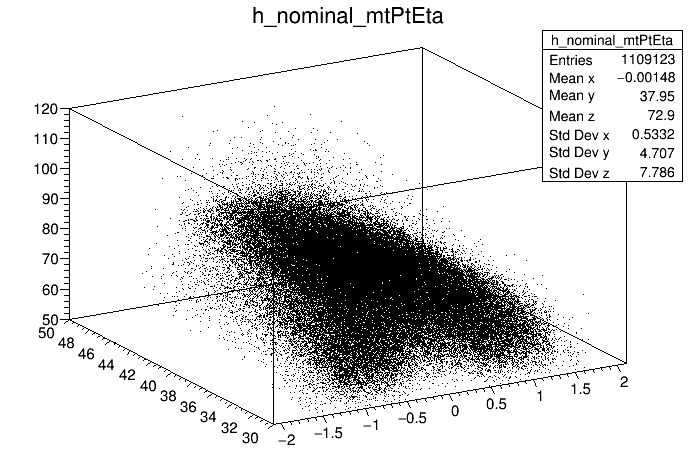

In [11]:
c = ROOT.TCanvas()
histList[0].Draw()
c.Draw()